# Setup

In [ ]:
# this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


FOLDERNAME = 'cs229_proj/'


assert FOLDERNAME is not None, "[!] Enter the foldername."

# now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

%cd drive/My\ Drive/$FOLDERNAME/

Mounted at /content/drive
/content/drive/My Drive/cs229_proj


In [ ]:
!pwd
!ls

In [ ]:
from IPython.display import Image
import json
import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math

import torch
from torch import nn

# Helper Functions

In [ ]:
# Uses folder and movie_id to create path where image can be found and displayed

def get_poster_path(movie_id, movie_data):
    folder_num = str(movie_data[3]) + "/"
    img_name = movie_id + '.jpg'
    return '/content/drive/My Drive/cs229_proj/letterboxd_posters/' + folder_num + img_name

# Load Files

## CSV files

In [ ]:
movies_full_path = '/content/drive/My Drive/cs229_proj/movies_full.csv'
user_ratings_full_path = '/content/drive/My Drive/cs229_proj/user_ratings_full.csv'
movies_full_df = pd.read_csv(movies_full_path)
ratings_full_df = pd.read_csv(user_ratings_full_path)

In [ ]:
movies_full_df

,movie_id,poster_path,title,year,1,2,3,4,5,6,7,8,9,10,tmdb_budget,imdb_budget,tmdb_revenue,imdb_revenue,tmdb_vote_average,tmdb_vote_count,imdb_vote_average,imdb_vote_count,tmdb_popularity,tmdb_runtime,imdb_runtime,main_genre,genres,director,writer,main_actor,mpaa_rating,overview,tagline,keywords,release_date,main_prod_company,production_companies,country,production_countries,original_language,spoken_languages,rt_info,critics_consensus,actors,tm_status,tm_rating,tm_count,audience_status,audience_rating,audience_count,tm_top_critics_count,tm_fresh_critics_count,tm_rotten_critics_count,ebert_rating,boxd_vote_average
0,pulp-fiction,1,Pulp Fiction,1994,1660,3821,1626,10863,7688,51895,47635,192128,117437,313059,8000000.0,8000000.0,2.139288e+08,2.139288e+08,8.3,8428.0,8.9,1900000.0,121.463076,154.0,154.0,Crime,"[""Thriller"", ""Crime""]",Quentin Tarantino,Quentin Tarantino,John Travolta,R,"A burger-loving hit man, his philosophical par...",Just because you are a character doesn't mean ...,"[""transporter"", ""brothel"", ""drug dealer"", ""box...",1994-10-08,Miramax,"[""Miramax Films"", ""A Band Apart"", ""Jersey Films""]",United States,"[""United States of America""]",en,"[""English"", ""Espa\u00f1ol"", ""Fran\u00e7ais""]",Vincent Vega (John Travolta) and Jules Winnfie...,One of the most influential films of the 1990s...,"John Travolta, Samuel L. Jackson, Uma Thurman,...",Certified-Fresh,92.0,106.0,Upright,96.0,1127813.0,32.0,97.0,9.0,4.0,8.645801
1,inception,1,Inception,2010,1250,3550,2063,13735,11410,71166,69034,232098,117643,245070,160000000.0,160000000.0,8.255328e+08,8.368370e+08,8.1,13752.0,8.8,2100000.0,167.583710,148.0,148.0,Action,"[""Action"", ""Thriller"", ""Science Fiction"", ""Mys...",Christopher Nolan,Christopher Nolan,Leonardo DiCaprio,PG-13,"Cobb, a skilled thief who commits corporate es...",Your mind is the scene of the crime.,"[""loss of lover"", ""dream"", ""kidnapping"", ""slee...",2010-07-14,Warner Bros.,"[""Legendary Pictures"", ""Warner Bros."", ""Syncopy""]",United States,"[""United Kingdom"", ""United States of America""]",en,"[""English"", ""\u65e5\u672c\u8a9e"", ""Fran\u00e7a...",Dom Cobb (Leonardo DiCaprio) is a thief with t...,"Smart, innovative, and thrilling, Inception is...","Leonardo DiCaprio, Ken Watanabe, Joseph Gordon...",Certified-Fresh,87.0,357.0,Upright,91.0,571078.0,65.0,310.0,47.0,4.0,8.347947
2,fight-club,1,Fight Club,1999,1069,2709,1501,9343,7963,50079,53178,191481,110863,240121,63000000.0,63000000.0,1.008538e+08,1.012097e+08,8.3,9413.0,8.8,1900000.0,146.757391,139.0,139.0,Drama,"[""Drama""]",David Fincher,Chuck Palahniuk,Brad Pitt,R,A ticking-time-bomb insomniac and a slippery s...,Mischief. Mayhem. Soap.,"[""support group"", ""dual identity"", ""nihilism"",...",1999-10-15,Fox 2000 Pictures,"[""Regency Enterprises"", ""Fox 2000 Pictures"", ""...",Germany,"[""Germany"", ""United States of America""]",en,"[""English""]",A depressed man (Edward Norton) suffering from...,"Solid acting, amazing direction, and elaborate...","Brad Pitt, Edward Norton, Helena Bonham Carter...",Certified-Fresh,79.0,173.0,Upright,96.0,1093242.0,40.0,137.0,36.0,2.0,8.516628
3,the-dark-knight,1,The Dark Knight,2008,757,1771,962,6094,5548,37917,40828,175350,125042,335098,185000000.0,185000000.0,1.004558e+09,1.005974e+09,8.2,12002.0,9.0,2400000.0,187.322927,152.0,152.0,Action,"[""Drama"", ""Action"", ""Crime"", ""Thriller""]",Christopher Nolan,Jonathan Nolan,Christian Bale,PG-13,Batman raises the stakes in his war on crime. ...,Why So Serious?,"[""dc comics"", ""crime fighter"", ""secret identit...",2008-07-16,Warner Bros.,"[""DC Comics"", ""Legendary Pictures"", ""Warner Br...",United States,"[""United Kingdom"", ""United States of America""]",en,"[""English"", ""\u666e\u901a\u8bdd""]",With the help of allies Lt. Jim Gordon (Gary O...,"Dark, complex, and unforgettable, The Dark Kni...","Christian Bale, Heath Ledger, Aaron Eckhart, M...",Certified-Fresh,94.0,340.0,Upright,94.0,1831566.0,63.0,320.0,20.0,4.0,8.845694
4,the-

In [ ]:
ratings_full_df

,user_id,movie_id,rating_val
0,shawn_stubbs,the-addams-family,9
1,ramiraff,the-truman-show,9
2,joshua_toomes,the-bourne-identity-2002,8
3,henryg9876,up,8
4,denny_crane,eight-legged-freaks,5
...,...,...,...
392546,jdoan,into-the-woods-2014,5
392547,jdoan,zero-dark-thirty,7
392548,jdoan,the-big-lebowski,9
392549,jdoan,aliens,8


In [ ]:
# print(movies_full_df.columns)

all_columns = ['movie_id', 'poster_path', 'title',
       'year', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       'tmdb_budget', 'imdb_budget', 'tmdb_revenue', 'imdb_revenue',
       'tmdb_vote_average', 'tmdb_vote_count', 'imdb_vote_average',
       'imdb_vote_count', 'tmdb_popularity', 'tmdb_runtime', 'imdb_runtime',
       'main_genre', 'genres', 'director', 'writer', 'main_actor',
       'mpaa_rating', 'overview', 'tagline', 'keywords', 'release_date',
       'main_prod_company', 'production_companies', 'country',
       'production_countries', 'original_language', 'spoken_languages',
       'rt_info', 'critics_consensus', 'actors', 'tm_status', 'tm_rating',
       'tm_count', 'audience_status', 'audience_rating', 'audience_count',
       'tm_top_critics_count', 'tm_fresh_critics_count',
       'tm_rotten_critics_count', 'ebert_rating', 'boxd_vote_average']
print(len(all_columns))

55


## JSON Files

In [ ]:
movieid_file_path = '/content/drive/My Drive/cs229_proj/movieid_to_data.json'
ratings_dict_file_path = '/content/drive/My Drive/cs229_proj/user_to_rating_dict.json'

user_to_rating_dict = {}
with open(ratings_dict_file_path, 'r') as fh:
    user_to_rating_dict = json.load(fh)

movieid_to_data = {}
with open(movieid_file_path, 'r') as fh:
    movieid_to_data = json.load(fh)

n_movies = len(movieid_to_data)
print(n_movies)

print(len(user_to_rating_dict)) # Number of Users

6833
5227


In [ ]:
user_counts = []
for user in user_to_rating_dict:
    cur_dict = user_to_rating_dict[user]
    user_counts.append(len(cur_dict))
print(sum(user_counts) / len(user_counts))  # Each user rated around 75 movies
print(sum(user_counts))                     # Sanity check - 392180
print(sum(user_counts) / 2220)              # Sanity check -- 176 users per movie

75.02965372106371
392180
176.65765765765767


# Exploratory Data Analysis

## User Ratings Exploration

In [ ]:
users = ratings_full_df['user_id'].tolist()

user_to_count = {}
for user in users:
    if user in user_to_count:
        user_to_count[user] += 1
    else:
        user_to_count[user] = 1


In [ ]:
counts = list(user_to_count.values())
print(sum(counts) / len(counts))

75.10063133728717


(array([355., 413., 455., 493., 451., 422., 390., 327., 297., 257., 189.,
        183., 147., 138., 112., 104.,  66.,  67.,  66.,  50.,  37.,  36.,
         31.,  26.,  20.,  18.,  19.,  20.,  13.,   4.,   3.,   3.,   3.,
          3.,   2.,   2.,   0.,   2.,   1.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.]),
 array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
        130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250,
        260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380,
        390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490]),
 <a list of 49 Patch objects>)

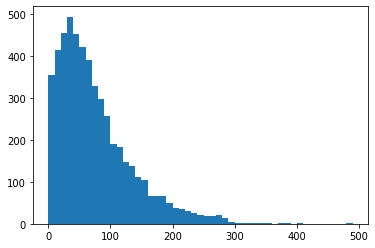

In [ ]:
plt.hist(counts, bins=[10*i for i in range(50)])

In [ ]:
print(user_to_count['bratpitt'])
print(user_to_count['deathproof'])
print(user_to_count['jdoan'])
print(user_to_count['ralfmakesmovies'])
print(user_to_count['ihe'])

66
114
402
182
83


In [ ]:
top_n = 1000
count = 0
for w in sorted(user_to_count, key=user_to_count.get, reverse=True):
    print(w, user_to_count[w])
    count += 1
    if count >= top_n:
        break

In [ ]:
movies = ratings_full_df['movie_id'].tolist()

In [ ]:
movie_to_count = {}
for movie in movies:
    if movie in movie_to_count:
        movie_to_count[movie] += 1
    else:
        movie_to_count[movie] = 1

In [ ]:
movie_counts = list(movie_to_count.values())
print(movie_counts)

print(sum(movie_counts) / len(movie_counts))

[236, 512, 266, 485, 86, 310, 234, 375, 303, 358, 285, 250, 488, 475, 184, 294, 121, 213, 502, 169, 205, 66, 157, 597, 92, 204, 121, 145, 356, 131, 234, 135, 153, 198, 131, 68, 205, 90, 123, 355, 181, 376, 73, 134, 242, 206, 499, 192, 408, 475, 218, 236, 322, 217, 406, 137, 408, 191, 260, 453, 451, 96, 218, 174, 342, 415, 207, 151, 114, 227, 97, 506, 107, 167, 309, 434, 351, 91, 41, 230, 200, 449, 120, 195, 82, 191, 119, 207, 98, 296, 139, 112, 117, 140, 262, 272, 485, 152, 413, 516, 128, 364, 188, 168, 85, 242, 54, 334, 350, 558, 100, 353, 429, 155, 155, 452, 72, 119, 168, 119, 166, 154, 230, 255, 367, 165, 340, 107, 147, 125, 459, 331, 261, 131, 36, 467, 419, 134, 367, 80, 122, 233, 94, 263, 228, 409, 299, 393, 516, 115, 380, 197, 272, 477, 152, 250, 82, 370, 337, 131, 179, 49, 88, 429, 204, 291, 190, 155, 247, 170, 150, 184, 151, 445, 108, 168, 362, 161, 363, 321, 261, 191, 122, 164, 388, 159, 142, 246, 566, 118, 111, 127, 86, 169, 245, 410, 227, 402, 193, 369, 198, 247, 45, 346, 51

In [ ]:
top_n = 100
count = 0
for w in sorted(movie_to_count, key=movie_to_count.get, reverse=True):
    print(w, movie_to_count[w])
    count += 1
    if count >= top_n:
        break

In [ ]:
top_n = 100
count = 0
for w in sorted(movie_to_count, key=movie_to_count.get, reverse=False):
    print(w, movie_to_count[w])
    count += 1
    if count >= top_n:
        break

(array([  0.,   5.,   8.,  35.,  62.,  91., 130., 127., 141., 124., 108.,
         90.,  94.,  99.,  60.,  75.,  75.,  81.,  56.,  68.,  53.,  41.,
         31.,  35.,  40.,  36.,  37.,  31.,  24.,  27.,  12.,  22.,  14.,
         16.,  28.,  22.,  23.,  17.,  13.,  10.,  14.,  10.,  16.,   9.,
         12.,  10.,  13.,   7.,   6.,   7.,   6.,  13.,   2.,   7.,   3.,
          2.,   4.,   3.,   2.,   4.,   4.,   3.,   0.,   1.,   0.,   1.,
          0.,   0.,   0.]),
 array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
        130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250,
        260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380,
        390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510,
        520, 530, 540, 550, 560, 570, 580, 590, 600, 610, 620, 630, 640,
        650, 660, 670, 680, 690]),
 <a list of 69 Patch objects>)

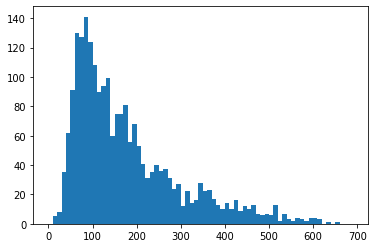

In [ ]:
plt.hist(movie_counts, bins=[10*i for i in range(70)])

## PCA Visualization - User Ratings and Critic Ratings

In [ ]:
import plotly.express as px

features = ['tmdb_vote_average', 'imdb_vote_average', 'boxd_vote_average', 'ebert_rating', 'audience_rating', 'tm_rating']

fig = px.scatter_matrix(
    movies_full_df,
    dimensions=features,
    # color=movies_full_df['mpaa_rating']
)
fig.update_traces(diagonal_visible=False)
fig.show()

In [ ]:
import plotly.express as px

# features = ['imdb_budget', 'imdb_revenue']
features = ['tmdb_budget', 'tmdb_revenue']

fig = px.scatter_matrix(
    movies_full_df,
    dimensions=features,
    color=movies_full_df['ebert_rating']
)
fig.update_traces(diagonal_visible=False)
fig.show()

In [ ]:
import plotly.express as px

# features = ['imdb_budget', 'imdb_revenue']
features = ['tmdb_budget', 'tmdb_revenue']

fig = px.scatter_matrix(
    movies_full_df,
    dimensions=features,
    color=movies_full_df['tm_rating']
)
fig.update_traces(diagonal_visible=False)
fig.show()

In [ ]:
import plotly.express as px

features = ['imdb_budget', 'imdb_revenue']
# features = ['tmdb_budget', 'tmdb_revenue']

fig = px.scatter_matrix(
    movies_full_df,
    dimensions=features,
    color=movies_full_df['boxd_vote_average']
)
fig.update_traces(diagonal_visible=False)
fig.show()

## Setting up One-Hot Encodings of Classification Features

In [ ]:
def add_one_hot_encoding(df, col_name):
    new_df = df.copy(True)
    feature_set = (set((new_df[col_name].tolist())))
    # create new columns
    print("Creating " + str(len(feature_set)) + " new features for " + col_name)
    for feature in feature_set:
        new_df[feature] = 0
    # assign 1 to the exact feature
    for feature in feature_set:
        new_df.loc[new_df[col_name] == feature, feature] = 1
    return new_df, list(feature_set)

In [ ]:
classification_features = ['main_genre', 'mpaa_rating', 'country', 'main_prod_company', 
                           'tm_status', 'audience_status', 'original_language'] # NOTE: don't do audience status (since that hints at user RT rating)
all_new_features = []
movies_full_new_df = movies_full_df.copy(True)

movies_full_new_df, cur_new_features = add_one_hot_encoding(movies_full_new_df, 'main_genre')
all_new_features += (cur_new_features)

movies_full_new_df, cur_new_features = add_one_hot_encoding(movies_full_new_df, 'mpaa_rating')
all_new_features += (cur_new_features)

# NOTE: might be redundant since it's just a cutoff for Critical Rating 
movies_full_new_df, cur_new_features = add_one_hot_encoding(movies_full_new_df, 'tm_status')
all_new_features += (cur_new_features)


# movies_full_new_df, cur_new_features = add_one_hot_encoding(movies_full_new_df, 'country')
# all_new_features += (cur_new_features)

# movies_full_new_df, cur_new_features  = add_one_hot_encoding(movies_full_new_df, 'main_prod_company')
# all_new_features += (cur_new_features)

# movies_full_new_df, cur_new_features  = add_one_hot_encoding(movies_full_new_df, 'original_language')
# all_new_features += (cur_new_features)

print(all_new_features)

Creating 14 new features for main_genre
Creating 9 new features for mpaa_rating
Creating 4 new features for tm_status
['Adventure', 'Fantasy', 'Crime', 'Horror', 'Comedy', 'Sci-Fi', 'Mystery', 'Romance', 'Drama', 'Biography', 'Animation', 'Action', 'Family', 'Thriller', nan, 'R', 'PG', 'PG-13', 'Unrated', 'NC-17', 'Not Rated', 'G', 'TV-MA', nan, 'Rotten', 'Fresh', 'Certified-Fresh']


In [ ]:
# print(movies_full_new_df.columns)
movies_full_new_df

# Baseline Models

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
from sklearn.impute import SimpleImputer

In [ ]:
# All features split up into many categories

regression_features = ['year', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       'tmdb_budget', 'imdb_budget', 'tmdb_revenue', 'imdb_revenue', 'tmdb_vote_average', 'tmdb_vote_count', 'imdb_vote_average',
       'imdb_vote_count', 'tmdb_popularity', 'tmdb_runtime', 'imdb_runtime', 'tm_rating',
       'tm_count', 'audience_rating', 'audience_count',
       'tm_top_critics_count', 'tm_fresh_critics_count',
       'tm_rotten_critics_count', 'ebert_rating', 'boxd_vote_average']

classification_features = ['main_genre', 'mpaa_rating', 'country', 'main_prod_company', 'tm_status', 'audience_status', 
                           'original_language']

complex_features = ['genres', 'director', 'writer', 'main_actor', 'overview', 'tagline', 'keywords', 'release_date', 
                    'production_companies', 'production_countries', 'spoken_languages', 'rt_info', 'critics_consensus', 
                    'actors']

other_features = ['movie_id', 'poster_path', 'title']

print(len(regression_features) + len(classification_features) + len(complex_features) + len(other_features))

55


## Data Preprocessing

In [ ]:
# Remove rows that have at least one NaN value (to make LinReg easier)
def remove_missing_values(X):
    old_len = X.shape[0]
    X = X[~np.isnan(X).any(axis=1)]
    new_len = X.shape[0]
    print("Removed " + str(old_len - new_len) + " out of " + str(old_len) + " elements or " + str((old_len - new_len)/old_len*100) + "%")
    print(str(new_len) + " elements remain")
    return X

In [ ]:
def get_num_missing(X):
    old_len = X.shape[0]
    X = X[~np.isnan(X).any(axis=1)]
    new_len = X.shape[0]
    return old_len - new_len

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html
# https://stackoverflow.com/questions/33113947/using-scikit-learn-sklearn-how-to-handle-missing-data-for-linear-regression
def impute_missing_values(X):
    pass

In [ ]:
def train_test_split(X, y, frac=0.8, verbose=False):
    train_len = int(X.shape[0] * frac)
    X_train = X[:train_len, :]
    y_train = y[:train_len]
    X_test = X[train_len:, :]
    y_test = y[train_len:]
    if verbose:
        print("X_train:", X_train.shape)
        print("y_train:", y_train.shape)
        print("X_test:", X_test.shape)
        print("y_test:", y_test.shape)
    return X_train, y_train, X_test, y_test

In [ ]:
output_to_best_features = {} # Tuple of (0-3, num-inputs) to List of [Sorted-List-Features, Sorted-Coef-Magnitudes]
output_to_rmse = {} # Tuple of (0-3, num-inputs) to List of [Train_RMSE, Test_RMSE]

In [ ]:
avg_boxd_features = ['year', 'tmdb_budget', 'imdb_budget', 'tmdb_revenue', 'imdb_revenue', 'tmdb_runtime', 'imdb_runtime', 
                     'tm_rating', 'tm_count', 'tm_top_critics_count', 'tm_fresh_critics_count', 
                     'tm_rotten_critics_count', 'ebert_rating']
# avg_boxd_features = ['year', 'tmdb_runtime', 'imdb_runtime', 
#                      'tm_rating', 'tm_count', 'tm_top_critics_count', 'tm_fresh_critics_count', 
#                      'tm_rotten_critics_count', 'ebert_rating'] # removed features with small coefficients
print(len(avg_boxd_features))
# I left out audience vote count (i.e. number of users who rated) since that seems pretty tied to average

output_feature_lst = ["boxd_vote_average", "audience_rating", "tmdb_vote_average", "imdb_vote_average"]
# Predict based on ONE of these 4 user ratings -- our main focus is boxd_vote_average

num_possible_outputs = len(output_feature_lst)

13


In [ ]:
for feature in avg_boxd_features:
    num_missing = get_num_missing(cur_df[[feature]].values)
    print(feature, num_missing)

year 0
tmdb_budget 0
imdb_budget 96
tmdb_revenue 0
imdb_revenue 2
tmdb_runtime 0
imdb_runtime 1
tm_rating 331
tm_count 331
tm_top_critics_count 329
tm_fresh_critics_count 329
tm_rotten_critics_count 329
ebert_rating 643


In [ ]:
# Attempt 1: just use regression features
cur_df = movies_full_df
input_features = avg_boxd_features
all_features_lst = avg_boxd_features + output_feature_lst

# # Attempt 2: add one-hot-encodings
# cur_df = movies_full_new_df
# input_features = avg_boxd_features + all_new_features
# all_features_lst = avg_boxd_features + all_new_features + output_feature_lst

In [ ]:
# Remove missing elements (TODO: impute missing values -- see above function)
X = remove_missing_values(cur_df[all_features_lst].values)
y = X[:, -num_possible_outputs:]
X = X[:, :-num_possible_outputs]

# TODO: change to 0, 1, 2, 3 for some fun
output_feature_idx = 0 # choose 0-3 for which output feature to try
print("Predicting on", output_feature_lst[output_feature_idx])
y = y[:,output_feature_idx]

# very important to shuffle
X, y = shuffle(X, y, random_state=5)

# Train-Test split
X_train, y_train, X_test, y_test = train_test_split(X, y, 0.8, True)

Removed 930 out of 2220 elements or 41.891891891891895%
1290 elements remain
Predicting on boxd_vote_average
X_train: (1032, 13)
y_train: (1032,)
X_test: (258, 13)
y_test: (258,)


## Linear Regression - Predict Average User Rating (Letterboxd and Rotten Tomatoes)

In [ ]:
reg = LinearRegression().fit(X_train, y_train)
print(reg.score(X_train, y_train))
print(reg.coef_)
print(reg.intercept_)
y_train_pred = reg.predict(X_train)
mse_train = mean_squared_error(y_train, y_train_pred)
print(mse_train)

0.7323013610387186
[-3.43147432e-02  6.25971570e-10 -5.07299197e-09 -2.15555682e-10
  2.98790717e-10  1.30073684e-03  9.09192093e-03  2.34490041e-02
 -2.24493585e-02  1.39971289e-02  2.37209207e-02  1.91272047e-02]
72.25893451268944
0.34594790219357363


In [ ]:
# Sort by Magnitude
zipped_lists = zip(input_features, reg.coef_)
sorted_pairs = sorted(zipped_lists, key=lambda tup: abs(tup[1]))

tuples = zip(*sorted_pairs)
sorted_features, sorted_coefs = [ list(tuple) for tuple in  tuples]
sorted_features.reverse()
sorted_coefs.reverse()

output_to_best_features[(output_feature_idx, len(input_features))] = [(sorted_features), (sorted_coefs)]

for i, feature in enumerate(sorted_features):
    if len(str(feature)) > 13:
        print(str(feature) + "\t", sorted_coefs[i])
    elif len(str(feature)) > 11:
        print(str(feature) + "\t\t", sorted_coefs[i])
    elif len(str(feature)) > 10:
        print(str(feature) + "\t\t\t\t", sorted_coefs[i])
    elif len(str(feature)) > 7:
        print(str(feature) + "\t\t", sorted_coefs[i])
    else:
        print(str(feature) + "\t\t\t", sorted_coefs[i])

year			 -0.03431474315774369
tm_fresh_critics_count	 0.023720920676260568
tm_rating		 0.023449004123776113
tm_count		 -0.022449358455771666
tm_rotten_critics_count	 0.01912720465274934
tm_top_critics_count	 0.013997128876171782
imdb_runtime		 0.009091920928088233
tmdb_runtime		 0.001300736843759884
imdb_budget				 -5.072991969857959e-09
tmdb_budget				 6.259715699621852e-10
imdb_revenue		 2.9879071721619666e-10
tmdb_revenue		 -2.155556822522948e-10


In [ ]:
y_pred = reg.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred)
print(mse_test)
print("\n")
print(mse_test - mse_train)
# Test error is less

output_to_rmse[(output_feature_idx, len(input_features))] = [mse_train, mse_test]

0.3481552219906999


0.0022073197971262948


In [ ]:
# True Value, Predicted Value

for i, cur_y in enumerate(y_pred):
    print(y_test[i], cur_y)

6.717732793522267 7.101083540760499
6.5246812683883615 5.9892611406276615
6.620643905890678 6.449341760228222
6.6910069019430365 7.059686670111475
7.074641926593069 6.68236809130218
7.1680245817447465 7.1825094158076155
7.642310401908622 6.731905616009271
4.739994606256743 4.898238663751641
6.578160869753541 6.3015010968801874
5.372561931640012 4.907887409949481
6.38311482103162 6.368244714585671
7.211228243950758 7.506528447169515
5.2753250464352055 5.388287202743754
4.768391298125088 5.244377204844454
5.8449205157945014 5.843950018813445
7.495245825602969 7.0746412615103935
6.674530078405862 7.139711921144695
5.627297619883453 7.163896046616131
7.761641920303843 6.575657199122162
8.168317064750008 7.816304310324966
5.186531097319423 4.788262066681355
5.673866321368022 5.9935642712161155
7.044672999921489 7.597653058488447
5.746354437546495 6.171356812517459
5.470921135856719 5.4311634210871205
5.736562364279362 6.089715993259588
5.026545217957058 5.273484728797342
4.5647385653338635 

In [ ]:
for key, value in output_to_rmse.items():
    print(key, [math.sqrt(i) for i in value])

In [ ]:
for output_idx, num_inputs in output_to_best_features:
    print(output_feature_lst[output_idx], num_inputs)
    print(output_to_best_features[(output_idx, num_inputs)][0])


## KNN on User Rating

In [ ]:
cur_df = movies_full_df
input_features = avg_boxd_features
all_features_lst = ['movie_id', 'audience_rating'] + avg_boxd_features + output_feature_lst
output_feature_lst = [] # ["audience_rating", "tmdb_vote_average", "imdb_vote_average"]
all_input_features = avg_boxd_features + output_feature_lst
print(all_features_lst)

# all_features_lst = ['movie_id', 'audience_rating'] + avg_boxd_features + output_feature_lst

['movie_id', 'audience_rating', 'year', 'tmdb_budget', 'imdb_budget', 'tmdb_revenue', 'imdb_revenue', 'tmdb_runtime', 'imdb_runtime', 'tm_rating', 'tm_count', 'tm_top_critics_count', 'tm_fresh_critics_count', 'tm_rotten_critics_count', 'ebert_rating']


In [ ]:
X_start = movies_full_df[all_features_lst]
X_start = X_start.dropna()
X_start = X_start.sample(frac=1).reset_index(drop=True)
X_start

,movie_id,audience_rating,year,tmdb_budget,imdb_budget,tmdb_revenue,imdb_revenue,tmdb_runtime,imdb_runtime,tm_rating,tm_count,tm_top_critics_count,tm_fresh_critics_count,tm_rotten_critics_count,ebert_rating
0,gremlins-2-the-new-batch,57.0,1990,50000000.0,50000000.0,41482207.0,41482207.0,106.0,106.0,71.0,65.0,17.0,46.0,19.0,2.5
1,moneyball,86.0,2011,50000000.0,50000000.0,110206216.0,110206216.0,133.0,133.0,94.0,266.0,55.0,250.0,16.0,4.0
2,flipped,78.0,2010,14000000.0,14000000.0,1755212.0,4324817.0,89.0,90.0,54.0,76.0,22.0,41.0,35.0,3.5
3,the-fisher-king,86.0,1991,24000000.0,24000000.0,41895491.0,41895491.0,137.0,137.0,84.0,61.0,11.0,51.0,10.0,2.0
4,elektra,29.0,2005,43000000.0,43000000.0,56681566.0,56995646.0,97.0,97.0,11.0,166.0,42.0,18.0,148.0,1.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1285,the-mexican,44.0,2001,57000000.0,57000000.0,147845033.0,147845033.0,123.0,123.0,54.0,133.0,36.0,72.0,61.0,3.0
1286,mission-impossible-iii,69.0,2006,150000000.0,150000000.0,397850012.0,398479497.0,126.0,126.0,71.0,224.0,51.0,158.0,66.0,2.5
1287,cool-runnings,81.0,1993,14000000.0,14000000.0,154864401.0,154856263.0,98.0,98.0,76.0,42.0,11.0,32.0,10.0,2.5
1288,the-mask-of-zorro,72.0,1998,95000000.0,95000000.0,250288523.0,250288523.0,136.0,136.0,82.0,73.0,15.0,60.0,13.0,3.0


In [ ]:
for col in X_start.columns:
    if col != 'movie_id' and col != 'boxd_vote_average' and col != 'audience_rating':
        X_start[col] = (X_start[col] - X_start[col].mean()) / X_start[col].std()

In [ ]:
X_start

,movie_id,audience_rating,year,tmdb_budget,imdb_budget,tmdb_revenue,imdb_revenue,tmdb_runtime,imdb_runtime,tm_rating,tm_count,tm_top_critics_count,tm_fresh_critics_count,tm_rotten_critics_count,ebert_rating
0,gremlins-2-the-new-batch,57.0,-1.517939,0.036140,0.000760,-0.572376,-0.600928,-0.341041,-0.343085,0.337901,-1.063611,-1.080964,-0.677901,-0.785998,-0.447428
1,moneyball,86.0,1.207650,0.036140,0.000760,-0.235683,-0.270855,0.946177,0.945843,1.278029,1.760681,1.356202,2.443428,-0.861099,1.345062
2,flipped,78.0,1.077860,-0.756918,-0.799041,-0.767006,-0.779390,-1.151511,-1.106894,-0.356976,-0.909048,-0.760284,-0.754404,-0.385460,0.747565
3,the-fisher-king,86.0,-1.388149,-0.536624,-0.576874,-0.570351,-0.598943,1.136876,1.136795,0.869277,-1.119816,-1.465780,-0.601398,-1.011301,-1.044924
4,elektra,29.0,0.428910,-0.118066,-0.154757,-0.497911,-0.526419,-0.770113,-0.772728,-2.114606,0.355561,0.522434,-1.106319,2.443343,-1.642421
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1285,the-mexican,44.0,-0.090249,0.190346,0.156277,-0.051282,-0.090081,0.469430,0.468462,-0.356976,-0.108129,0.137619,-0.280085,0.265415,0.150069
1286,mission-impossible-iii,69.0,0.558700,2.239081,2.222430,1.173543,1.113683,0.612454,0.611676,0.337901,1.170531,1.099658,1.035770,0.390583,-0.447428
1287,cool-runnings,81.0,-1.128569,-0.756918,-0.799041,-0.016893,-0.056407,-0.722439,-0.724990,0.542277,-1.386789,-1.465780,-0.892110,-1.011301,-0.447428
1288,the-mask-of-zorro,72.0,-0.479619,1.027464,1.000512,0.450609,0.401941,1.089202,1.089057,0.787527,-0.951201,-1.209236,-0.463692,-0.936200,0.150069


In [ ]:
X = X_start[all_input_features] # get rid of movie_id and boxd_vote_average

train_frac = 0.8
train_end_idx = int(X.shape[0] * train_frac)

X_train = X.loc[:train_end_idx, :]
X_test = X.loc[train_end_idx + 1:, :]

X_train_all = X_start.loc[:train_end_idx, :]
X_test_all = X_start.loc[train_end_idx + 1:, :]

assert X_train.shape[0] + X_test.shape[0] == X.shape[0]

In [ ]:
print(X_train.shape)
print(X_test.shape)

(1033, 13)
(257, 13)


In [ ]:
# X_test_all

# random_idx = 1
# sample_embed = np.array(X.loc[train_end_idx + random_idx, 'year':])
# sample_embed = torch.tensor(sample_embed).float()
# sample_embed = sample_embed.reshape((1, sample_embed.shape[0]))
# # print(sample_embed)
# X_start.iloc[train_end_idx + random_idx, :]

In [ ]:
# gets representations for every movie...?? if we can run this once and store it somewhere...
def get_embeddings(cur_X):
  # let's start with the stupid one: just return the letterboxd histogram
  movie_embedding = np.array(cur_X)
  return torch.tensor(movie_embedding).float()

E = get_embeddings(X_train)

# dists = nn.CosineSimilarity()(sample_embed, E)
# knn = dists.topk(10, largest=True)
# X_start.iloc[knn.indices.tolist()]

# top_10_similar = X_start.iloc[knn.indices.tolist()]
# top_10_boxd_avgs = top_10_similar['boxd_vote_average'].tolist()
# print(top_10_boxd_avgs)




In [ ]:
# k_list = [i for i in range(1, 100)]
k_list = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100]
k_to_rmse = {}

In [ ]:
col_name = 'audience_rating'

y_true_train = X_train_all[col_name].tolist()
y_true = X_test_all[col_name].tolist()

for k in k_list:
    

    y_pred_train = []

    for i in range(0, X_train.shape[0]):
        cur_embed = np.array(X.loc[i, 'year':])
        cur_embed = torch.tensor(cur_embed).float()
        cur_embed = cur_embed.reshape((1, cur_embed.shape[0]))
        dists = nn.CosineSimilarity()(cur_embed, E)
        knn = dists.topk(k + 1, largest=True)
        top_10_similar = X_start.iloc[knn.indices.tolist()]
        top_10_boxd_avgs = top_10_similar[col_name].tolist()[1:]
        y_pred_train.append(sum(top_10_boxd_avgs) / len(top_10_boxd_avgs))

    y_pred = []

    for i in range(1, X_test.shape[0] + 1):
        cur_embed = np.array(X.loc[train_end_idx + i, 'year':])
        cur_embed = torch.tensor(cur_embed).float()
        cur_embed = cur_embed.reshape((1, cur_embed.shape[0]))
        dists = nn.CosineSimilarity()(cur_embed, E)
        knn = dists.topk(k, largest=True)
        top_10_similar = X_start.iloc[knn.indices.tolist()]
        top_10_boxd_avgs = top_10_similar[col_name].tolist()
        y_pred.append(sum(top_10_boxd_avgs) / len(top_10_boxd_avgs))


    rmse_test = math.sqrt(mean_squared_error(y_true, y_pred))
    rmse_train = math.sqrt(mean_squared_error(y_true_train, y_pred_train))

    k_to_rmse[k] = [rmse_train, rmse_test]

In [ ]:
for key, value in k_to_rmse.items():
    print(key, value)

3 [13.231305344146339, 13.052920321655074]
4 [12.939051219722494, 12.979012540904835]
5 [12.707744740097564, 12.682620848836045]
6 [12.502446786451783, 12.441301869896849]
7 [12.300625653570195, 12.209355892814271]
8 [12.227008745420942, 12.150375588660841]
9 [12.17313374547348, 12.184686692993308]
10 [12.083165346942367, 12.154941670114713]
11 [12.076946292311558, 12.120083369210457]
12 [12.034445058273365, 12.231854794961901]
13 [12.016725228458276, 12.162706714520539]
14 [11.962097329775268, 12.147036033374276]
15 [11.945698371536789, 12.236860392673421]
20 [11.996153384772041, 12.023957925838506]
30 [12.026805286150863, 12.006832253024516]
40 [12.103577221572442, 12.041115623850063]
50 [12.170827674114497, 12.096508870258768]
60 [12.238968972689939, 12.204275021228188]
70 [12.258285965292336, 12.25717353330246]
80 [12.320443553305767, 12.32140267033715]
90 [12.338799210730999, 12.461247283644983]
100 [12.382261845966255, 12.527002103937809]


In [ ]:
# y_pred[:10]

# y_true = X_test_all['boxd_vote_average'].tolist()
# y_true[:10]

In [ ]:
print(len(y_true))

mse_test = mean_squared_error(y_true, y_pred)
print(math.sqrt(mse_test))

In [ ]:
print(len(y_true_train))

mse_train = mean_squared_error(y_true_train, y_pred_train)
print(math.sqrt(mse_train))